#### Table of Contents
- [Prediction with RNN](#prediction-with-rnn)
    - [1. Data Preparation and Cleaning](#data-preparation-and-cleaning)
        - [i. Data Extraction](#extracting-neccessary-data)
        - [ii. Data Manupilation](#manupilating-data)
        - [iii. Data Normalisation](#data-normalisation)
        - [iv. Building Dataset](#building-dataset)
    - [2. RNN](#recurrent-neural-network)
        - [i. Building model](#building-model)
        - [ii. Data Loader](#data-loader)
        - [iii. Training Model](#training-model)
        - [iv. Loss/Accuracy](#training-and-validation-lossaccuracy)
        - [v. Testing model](#testing-the-model)
        - [vi. Predicting Matches](#predicting-match-result-with-model)
        - [vii. SWC 2016](#predicting-2016-season-world-championship-finals)
    - [3. Conclusion](#conclusion)

# Prediction with RNN

**Recurrent Neural Network(RNN)** is a type of Neural Network where the output from the previoud steps is fed as input to the current step.   

We will be using PyTorch's RNN model to predict the result of a game from 30 mins(the shorter the time, the less accurate is the model)   
We will be using the top 5 variables we have chosen on top in our analysis. But we will also use gold diff since I personally thinks that it is a important variable.

In [15]:
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning, DeprecationWarning))
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from ast import literal_eval
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

---
### Data Preparation and Cleaning
Here we will prepare and clean the dataset. Some part is same as in EDA.

In [16]:
# Same as in EDA
# Import Dataset
league_data = pd.read_csv("datasets/LeagueofLegends.csv")

# Make a copy of df to work with
clean_df = league_data.copy(deep=True)

# Make a new column to show winners
clean_df['winner'] = np.where(clean_df['bResult'] == 1, 1, 2)

# Convert columns with lists object to real lists
cols = ['bKills', 'rKills', 'goldblue', 'goldred', 'bTowers', 'rTowers', 'bInhibs', 'rInhibs', 'bDragons', 'rDragons', 'bBarons', 'rBarons', 'bHeralds', 'rHeralds', 'golddiff']

for col in cols:
    clean_df[col] = clean_df[col].apply(literal_eval)


#### Extracting neccessary data

here we will extract information that we need

In [17]:
T_LENGTH = 30

new_df = pd.DataFrame()

new_df['blueTeamTag'] = clean_df['blueTeamTag']
new_df['bKills'] = clean_df['bKills']
new_df['bTowers'] = clean_df['bTowers']
new_df['bDragons'] = clean_df['bDragons']
new_df['bInhibs'] = clean_df['bInhibs']
new_df['bBarons'] = clean_df['bBarons']

new_df['redTeamTag'] = clean_df['redTeamTag']
new_df['rKills'] = clean_df['rKills']
new_df['rTowers'] = clean_df['rTowers']
new_df['rDragons'] = clean_df['rDragons']
new_df['rInhibs'] = clean_df['rInhibs']
new_df['rBarons'] = clean_df['rBarons']

new_df['gamelength'] = clean_df['gamelength']
new_df['golddiff'] = clean_df['golddiff']
new_df['winner'] = clean_df['bResult']
new_df['League'] = clean_df['League']
new_df['Year'] = clean_df['Year']


new_df = new_df[new_df['gamelength'] >= T_LENGTH]
new_df = new_df.reset_index(drop=True)
new_df.head()

,blueTeamTag,bKills,bTowers,bDragons,bInhibs,bBarons,redTeamTag,rKills,rTowers,rDragons,rInhibs,rBarons,gamelength,golddiff,winner,League,Year
0,TSM,"[[10.82, C9 Hai, TSM Bjergsen, [], 9229, 8469]...","[[27.542, MID_LANE, BASE_TURRET], [39.269, MID...","[[37.267, None]]","[[36.686, MID_LANE], [29.274, MID_LANE]]",[],C9,"[[16.529, TSM Lustboy, C9 Balls, [C9 Meteos, C...","[[39.23, TOP_LANE, INNER_TURRET], [20.681, MID...","[[17.14, None], [30.934, None], [24.641, None]]",[],[[29.954]],40,"[0, 0, -14, -65, -268, -431, -488, -789, -494,...",1,NALCS,2015
1,CST,"[[11.104, DIG Shiphtur, CST Jesiz, [CST Impale...","[[23.239, BOT_LANE, OUTER_TURRET], [33.018, BO...","[[32.545, None], [26.177, None], [19.119, None]]",[],[[29.255]],DIG,"[[12.387, CST Jesiz, DIG Gamsu, [DIG Shiphtur]...","[[19.257, MID_LANE, OUTER_TURRET], [15.206, BO...","[[12.264, None]]","[[36.813, MID_LANE]]",[],38,"[0, 0, -26, -18, 147, 237, -152, 18, 88, -242,...",0,NALCS,2015
2,WFX,"[[5.255, GV Keane, WFX Pobelter, [WFX ShorterA...","[[15.045, BOT_LANE, OUTER_TURRET], [39.566, MI...","[[24.577, None], [37.867, None], [30.87, None]...","[[37.511, TOP_LANE], [37.38, BOT_LANE], [39.32...",[[35.144]],GV,"[[8.449, WFX Altec, GV Cop, [GV BunnyFuFuu], 1...","[[24.62, MID_LANE, OUTER_TURRET], [30.493, TOP...",[],[],[],40,"[0, 0, 10, -60, 34, 37, 589, 1064, 1258, 913, ...",1,NALCS,2015
3,TIP,"[[8.274, TL Quas, TIP Rhux, [TIP Apollo], 3491...","[[19.941, BOT_LANE, OUTER_TURRET], [38.77, TOP...",[],[],[[37.513]],TL,"[[7.768, TIP Rush, TL IWDominate, [TL Fenix], ...","[[36.384, MID_LANE, NEXUS_TURRET], [31.665, MI...","[[26.274, None], [10.153, None], [18.515, None...","[[35.867, MID_LANE]]",[],41,"[0, 0, -15, 25, 228, -6, -243, 175, -346, 16, ...",0,NALCS,2015
4,CLG,"[[11.438, T8 Dodo8, CLG Doublelift, [CLG Xmith...","[[22.594, MID_LANE, OUTER_TURRET], [34.213, MI...","[[14.589, None], [30.307, None]]","[[34.069, BOT_LANE]]",[[32.556]],T8,"[[11.988, CLG Doublelift, T8 Porpoise8, [T8 Sl...","[[11.644, MID_LANE, OUTER_TURRET], [12.438, BO...","[[21.901, None]]",[],[],35,"[40, 40, 44, -36, 113, 158, -121, -191, 23, 20...",1,NALCS,2015


#### Manupilating Data

here we will combine the column of red and blue

In [18]:
# helper function to convert variables into an array showing how many of that event occurred every minute in the game
def to_array(x):
    array = np.zeros(T_LENGTH, dtype=np.int8) # an array of zeros of length=T_LENGTH, here we will use the smallest int8 since the number wont be big
    for time in range(T_LENGTH):
        for item in x:
            if item[0] <= time+1:
                array[time] += 1

    return array

In [19]:
# combine red and blue variables by making a new columns representing their differences
final_df = pd.DataFrame()

final_df['kill_diff'] = new_df['bKills'].apply(to_array) - new_df['rKills'].apply(to_array)
final_df['tower_diff'] = new_df['bTowers'].apply(to_array) - new_df['rTowers'].apply(to_array)
final_df['dragon_diff'] = new_df['bDragons'].apply(to_array) - new_df['rDragons'].apply(to_array)
final_df['inhib_diff'] = new_df['bInhibs'].apply(to_array) - new_df['rInhibs'].apply(to_array)
final_df['baron_diff'] = new_df['bBarons'].apply(to_array) - new_df['rBarons'].apply(to_array)
final_df['gold_diff'] = new_df['golddiff']
final_df['winner'] = new_df['winner']
final_df.head()

,kill_diff,tower_diff,dragon_diff,inhib_diff,baron_diff,gold_diff,winner
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, -14, -65, -268, -431, -488, -789, -494,...",1
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, -26, -18, 147, 237, -152, 18, 88, -242,...",0
2,"[0, 0, 0, 0, 0, 1, 2, 2, 1, 1, 2, 2, 5, 5, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 10, -60, 34, 37, 589, 1064, 1258, 913, ...",1
3,"[0, 0, 0, 0, 0, 0, 0, -1, 0, -1, -1, -1, -1, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, -15, 25, 228, -6, -243, 175, -346, 16, ...",0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -2, -2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[40, 40, 44, -36, 113, 158, -121, -191, 23, 20...",1


#### Data Normalisation

We have to normalise the data since each variables have different scales. For example gold_diff can be in the hundreds and thousands compared to dragon_diff or tower_diff which is usually below 10. This is to prevent variables with larger scales from dominating those with smaller scales.

In [20]:
# normalization of data using StardardScalers to transform data to a mean of 0 and s.d. of 1
variables = ['kill_diff', 'tower_diff', 'dragon_diff', 'inhib_diff', 'baron_diff', 'gold_diff']
x = final_df[variables]
y = final_df['winner'] 

data = {}
scalers = {}
for variable in variables:
    scalers[variable] = StandardScaler()
    for row in final_df[variable]:
        scalers[variable].partial_fit(np.asanyarray(row).reshape(-1,1)) # partial fit due to large data set and requires 2D array as input
    data[variable] = [scalers[variable].transform(np.asanyarray(row).reshape(-1,1)).reshape(-1) for row in final_df[variable]] # transform and convert back to 1D array

num_features = len(data)

#### Building Dataset

Here we will make the pytorch tensor.   
PyTorch tensor is basically numpy array and it is a fundamental data structure for neural network models

In [21]:
class LeagueDataset(Dataset):
    def __init__(self, data, variables, label):
        # Initialize the dataset by constructing a list of features for each time step of each match
        self.data = []
        for t in range(T_LENGTH):
            self.data.append([[data[variable][i][t] for variable in variables] for i in range(len(final_df))])
        # Store the labels as a tensor
        self.label = torch.tensor(label)
        
    def __getitem__(self, item):
        # Construct the feature tensor for the given item index
        features = [[torch.scalar_tensor(i) for i in x[item]] for x in self.data]
        # Return the feature tensor and label tensor as a tuple
        return torch.tensor(features), self.label[item]

    def __len__(self):
        # Return the length of the dataset
        return len(self.label)


---
### Recurrent Neural Network

#### Building model

Here we will build our RNN using PyTorch's RNN model

We will be using the **Cross-entropy loss** for our loss function:
$$
  L_{ce} = -\sum\nolimits_{i=1}^n t_i log(p_i), \text{for n classes, where } t_i \text{ is the truth label and } p_i \text{ is the Softmax probability for the } i^{th} \text{ class.}
$$

and we will be using **Stochastic gradient descent(SGD)** as our optimiser.

In [22]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        
        # Define RNN layer with ReLU activation function
        self.rnn = nn.RNN(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers, batch_first=True, nonlinearity='relu')

        # Define output linear layer
        self.out = nn.Linear(self.hidden_size, 2)
    
    def forward(self,x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, len(x), self.hidden_size)

        # Feed input into RNN layer
        r_out, _ = self.rnn(x, h0)

        # Use output of last time step as input to output layer
        out = self.out(r_out[:, -1, :])
        return out

#### Data Loader

Here we will split the dataset into 7:2:1 train:validation:test set and load the data with DataLoader

In [23]:
# Define the split ratios
TRAIN_RATIO = 0.7
VALID_RATIO = 0.2
TEST_RATIO = 0.1
dataset = LeagueDataset(data, variables, final_df["winner"])

# Calculate the sizes of the train, validation, and test sets
num_samples = len(dataset)
train_size = int(num_samples * TRAIN_RATIO)
valid_size = int(num_samples * VALID_RATIO)
test_size = num_samples - train_size - valid_size

# Split the dataset into train, validation, and test sets
train_set, valid_set, test_set = random_split(
    dataset=dataset, 
    lengths=[train_size, valid_size, test_size], 
    generator=torch.Generator().manual_seed(0)
)

# Define the batch size
BATCH_SIZE = 16

# Create data loaders for the train, validation, and test sets
train_loader = DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_loader = DataLoader(
    dataset=valid_set,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [24]:
# setting of parameters
input_size = len(data)
hidden_size = 128
num_layers = 1
num_epochs = 100

model = RNN(input_size, hidden_size, num_layers)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)
print(model)

RNN(
  (rnn): RNN(6, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=2, bias=True)
)


In [25]:
# helper function for training the model
def train(loader, epoch, model, criterion, optimiser):
    model.train()
    n_total_steps = len(loader.dataset)
    loss_t, correct =0,0
    for i, (x,y) in enumerate(loader):
        x, y = Variable(x), Variable(y)

        # Forward pass
        predict = model(x)
        loss = criterion(predict, y)

        # Backward and optimize
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        loss_t += loss.item()
        correct += (predict.argmax(dim=1) == y).sum().item()

        if i % 50 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i*len(x)}/{n_total_steps}], Loss: {loss.item():.4f}')
    avg_loss = loss_t / n_total_steps
    avg_accuracy = correct / n_total_steps

    return avg_accuracy, avg_loss

In [26]:
# helper function for testing the model
def test(loader, model, criterion):
    model.eval()
    n_samples = len(loader.dataset)
    correct, loss = 0, 0

    with torch.no_grad():
        for i, (x,y) in enumerate(loader):
            x, y = Variable(x), Variable(y)
            predict = model(x)
            loss += criterion(predict, y).item()
            correct += (predict.argmax(dim=1) == y).sum().item()
            
    
    avg_loss = loss / n_samples
    avg_accuracy = correct / n_samples
    print(f"Test Accuracy:{avg_accuracy:.6f} | Avg loss:{avg_loss:.6f}")

    return avg_accuracy, avg_loss

#### Training model

Here we will iteratively train the model over our `num_epochs` times which we can change.   
We will also early terminate the training if the next 5 iteration's accuracy is lower than the best accuracy.

In [27]:
best_accuracy = 0
earlystop_count = 0
earlystop_limit = 5

validation_losses = []
train_losses = []
validation_acc = []
train_acc = []

for epoch in range(1, num_epochs+1):
    # size = len(train_loader.dataset)
    train_accuracy, train_loss = train(train_loader, epoch, model, criterion, optimiser)
    valid_accuracy, valid_loss = test(valid_loader, model, criterion)
    train_acc.append(train_accuracy)
    train_losses.append(train_loss)
    validation_acc.append(valid_accuracy)
    validation_losses.append(valid_loss)

    if valid_accuracy > best_accuracy:
        earlystop_count = 0
        best_accuracy = valid_accuracy
        torch.save(model.state_dict(), f"./{T_LENGTH}minute_matches.pt") # save the best model 
    else:
        earlystop_count += 1
        if earlystop_count >= earlystop_limit:
            print(f"Early stopped. Epoch #{epoch}. Best Validation accuracy {best_accuracy*100:.2f}%.")
            break

Epoch [1/100], Step [0/4468], Loss: 0.6705
Epoch [1/100], Step [800/4468], Loss: 0.6198
Epoch [1/100], Step [1600/4468], Loss: 0.6229
Epoch [1/100], Step [2400/4468], Loss: 0.6279
Epoch [1/100], Step [3200/4468], Loss: 0.5802
Epoch [1/100], Step [4000/4468], Loss: 0.6187
Test Accuracy:0.781348 | Avg loss:0.038415
Epoch [2/100], Step [0/4468], Loss: 0.6110
Epoch [2/100], Step [800/4468], Loss: 0.6407
Epoch [2/100], Step [1600/4468], Loss: 0.6385
Epoch [2/100], Step [2400/4468], Loss: 0.6260
Epoch [2/100], Step [3200/4468], Loss: 0.5685
Epoch [2/100], Step [4000/4468], Loss: 0.5879
Test Accuracy:0.807994 | Avg loss:0.037255
Epoch [3/100], Step [0/4468], Loss: 0.5684
Epoch [3/100], Step [800/4468], Loss: 0.5933
Epoch [3/100], Step [1600/4468], Loss: 0.6062
Epoch [3/100], Step [2400/4468], Loss: 0.5816
Epoch [3/100], Step [3200/4468], Loss: 0.6157
Epoch [3/100], Step [4000/4468], Loss: 0.6575
Test Accuracy:0.818966 | Avg loss:0.036211
Epoch [4/100], Step [0/4468], Loss: 0.5579
Epoch [4/100

#### Training and Validation loss/accuracy

Lets look at the Validation accuracy/loss vs Training accuracy/loss graph. We can observe that the accuracy increase significantly for the first few interations, and plateus out afterwards. Same for the losses, which decreases quickly at first and plateues out afterwards.

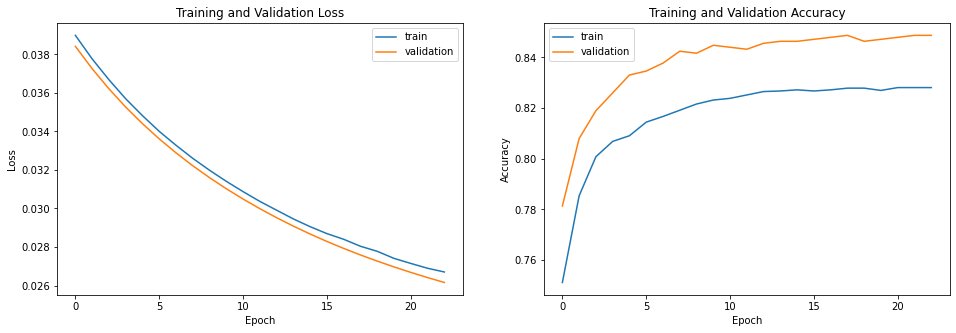

In [28]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))

ax1.set_title("Training and Validation Loss")
ax1.plot(train_losses, label="train")
ax1.plot(validation_losses, label="validation")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.set_title("Training and Validation Accuracy")
ax2.plot(train_acc, label="train")
ax2.plot(validation_acc, label="validation")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()

#### Testing the model

Here we will load the best accuracy model from on top to test it with our test set

In [29]:
model.load_state_dict(torch.load(f"./{T_LENGTH}minute_matches.pt"))   # load the best trained model from above
RNN_accuracy, _ = test(test_loader, model, criterion)      # test on test_set

print(f'Model Accuracy = {RNN_accuracy*100:>.2f}%')

Test Accuracy:0.835938 | Avg loss:0.027274
Model Accuracy = 83.59%


Looks like we are able to get a model with ~84% accuracy

#### Predicting match result with model

We can also ask the model to predict the outcome of a specific match we are interested in

In [30]:
# helper function to predict the inputted data
def predict(x):
    model.eval()
    with torch.no_grad():
        x = torch.from_numpy(x)
        predict = model(x)
        winner = ['RED', 'BLUE'][predict.argmax(1)]
        prob_red = math.exp(predict[0][0].item()) / (math.exp(predict[0][0].item()) + math.exp(predict[0][1].item()))
        prob_blue = math.exp(predict[0][1].item()) / (math.exp(predict[0][0].item()) + math.exp(predict[0][1].item()))
        print(f"Predicted winner: { winner }")
        print(f"blue wins probability: {prob_blue * 100 :.1f}% || red wins probability: {prob_red * 100:.1f}%")
    

In [31]:
# helper function to normalise and convert df to required form
def match_data(match_df):
    match_data = {}
    match_data['kill_diff'] = (match_df['bKills'].apply(to_array) - match_df['rKills'].apply(to_array)).values.tolist()[0]
    match_data['tower_diff'] = (match_df['bTowers'].apply(to_array) - match_df['rTowers'].apply(to_array)).values.tolist()[0]
    match_data['dragon_diff'] = (match_df['bDragons'].apply(to_array) - match_df['rDragons'].apply(to_array)).values.tolist()[0]
    match_data['inhib_diff'] = (match_df['bInhibs'].apply(to_array) - match_df['rInhibs'].apply(to_array)).values.tolist()[0]
    match_data['baron_diff'] = (match_df['bBarons'].apply(to_array) - match_df['rBarons'].apply(to_array)).values.tolist()[0]
    match_data['gold_diff'] = (match_df['golddiff']).values.tolist()[0]

    for variable in variables:
        match_data[variable] = scalers[variable].transform(np.asanyarray(match_data[variable]).reshape(-1, 1)).reshape(-1)

        x = np.asarray([[[match_data[variable][timestep] for variable in variables] for timestep in range(T_LENGTH)]], dtype=np.float32)

    return x

#### Predicting 2016 Season World Championship Finals

Here lets take a look at the League of Legends Season World Championship 2016's Finals SKT vs Samsung Galaxy's match


In [32]:
temp = clean_df[clean_df['League'] == 'WC']
temp = temp[temp['Year'] == 2016]
temp = temp[(temp['blueTeamTag'] == 'SKT') | (temp['redTeamTag'] == 'SKT')]
temp = temp[(temp['blueTeamTag'] == 'SSG') | (temp['redTeamTag'] == 'SSG')]
temp = temp.reset_index(drop=True)
temp.head(10)

,League,Year,Season,Type,blueTeamTag,bResult,rResult,redTeamTag,gamelength,golddiff,...,goldredMiddle,redADC,redADCChamp,goldredADC,redSupport,redSupportChamp,goldredSupport,redBans,Address,winner
0,WC,2016,Summer,International,SSG,0,1,SKT,55,"[0, 16, -66, -208, -312, -89, -362, -265, -387...",...,"[500, 500, 595, 893, 1330, 1572, 1855, 2295, 2...",Bang,Jhin,"[500, 500, 561, 865, 1225, 1473, 1839, 2204, 2...",Wolf,Karma,"[500, 511, 531, 703, 902, 1109, 1295, 1476, 16...","['Nidalee', 'MissFortune', 'Ryze']",http://matchhistory.na.leagueoflegends.com/en/...,2
1,WC,2016,Summer,International,SKT,1,0,SSG,32,"[0, 0, -50, -259, -539, -808, -769, -959, -114...",...,"[500, 500, 561, 888, 1242, 1572, 1985, 2368, 2...",Ruler,Caitlyn,"[500, 500, 541, 885, 1276, 1535, 1752, 2160, 2...",CoreJJ,Karma,"[500, 527, 550, 747, 939, 1097, 1269, 1451, 16...","['Syndra', 'Ashe', 'Nidalee']",http://matchhistory.na.leagueoflegends.com/en/...,1
2,WC,2016,Summer,International,SSG,1,0,SKT,72,"[0, 0, 34, 120, 89, -199, -145, -19, -40, -725...",...,"[500, 500, 579, 865, 1198, 1597, 1987, 2165, 2...",Bang,Jhin,"[500, 500, 542, 828, 1208, 1565, 1909, 2244, 2...",Wolf,Nami,"[500, 500, 534, 705, 887, 1069, 1233, 1373, 15...","['Nidalee', 'Olaf', 'Ryze']",http://matchhistory.na.leagueoflegends.com/en/...,1
3,WC,2016,Summer,International,SKT,0,1,SSG,47,"[0, -8, 67, 45, -95, 66, -144, -9, -192, -263,...",...,"[500, 500, 562, 930, 1295, 1706, 1924, 2197, 2...",Ruler,Jhin,"[500, 500, 502, 788, 1143, 1339, 1884, 2047, 2...",CoreJJ,Karma,"[500, 508, 547, 702, 869, 1009, 1160, 1346, 15...","['Syndra', 'Ryze', 'Nidalee']",http://matchhistory.na.leagueoflegends.com/en/...,2
4,WC,2016,Summer,International,SSG,0,1,SKT,50,"[0, 0, -11, 67, -584, -411, -434, -747, -723, ...",...,"[500, 500, 561, 874, 1351, 1473, 1827, 2205, 2...",Bang,Ashe,"[500, 500, 587, 931, 1321, 1643, 1990, 2348, 2...",Wolf,Braum,"[500, 500, 501, 701, 1482, 1641, 1806, 2038, 2...","['Nidalee', 'Zyra', 'AurelionSol']",http://matchhistory.na.leagueoflegends.com/en/...,2


In [36]:
print('====================LoL 2016 WC Finals====================')
print('=============MATCH 1: (BLUE) SSG vs SKT (RED)=============')
x = match_data(temp.iloc[[0]])
predict(x)
print()
print('=============MATCH 2: (BLUE) SKT vs SSG (RED)=============')
x = match_data(temp.iloc[[1]])
predict(x)
print()
print('=============MATCH 3: (BLUE) SSG vs SKT (RED)=============')
x = match_data(temp.iloc[[2]])
predict(x)
print()
print('=============MATCH 4: (BLUE) SKT vs SSG (RED)=============')
x = match_data(temp.iloc[[3]])
predict(x)
print()
print('=============MATCH 5: (BLUE) SSG vs SKT (RED)=============')
x = match_data(temp.iloc[[4]])
predict(x)


====================LoL 2016 WC Finals====================
=============MATCH 1: (BLUE) SSG vs SKT (RED)=============
Predicted winner: RED
blue wins probability: 42.6% || red wins probability: 57.4%

=============MATCH 2: (BLUE) SKT vs SSG (RED)=============
Predicted winner: BLUE
blue wins probability: 77.5% || red wins probability: 22.5%

=============MATCH 3: (BLUE) SSG vs SKT (RED)=============
Predicted winner: RED
blue wins probability: 41.0% || red wins probability: 59.0%

=============MATCH 4: (BLUE) SKT vs SSG (RED)=============
Predicted winner: BLUE
blue wins probability: 52.6% || red wins probability: 47.4%

=============MATCH 5: (BLUE) SSG vs SKT (RED)=============
Predicted winner: BLUE
blue wins probability: 52.9% || red wins probability: 47.1%


---
### Conclusion

As we can see, our model predicted the match results from 30 minutes to be **SKT 4:1 SSG**   
however, the actual score for this finals is **SKT 3:2 SSG**   
This could be because in match 3, the game length is 72 minutes, which is more than double the game length our model is build on, hence decreasing its accuracy
However we can see that if the game length stays relatively close to 30 minute, our model is able to accurately predict the winning team despite only using data from the first 30 minutes   
We can thus conclude that in most games (85%) the outcome can already be determined in the first 30 minutes

---
End~